# Tasting Data : Exploring Morocco's Food Industry and Making Some Recommendations
#### By Mohammed Said ANEZARY
Linkedin = [link to LinkedIn](https://www.linkedin.com/in/msanezary/)

### Project's objective:
The goal of this project is to extract and analyze data related to moroccan restaurants and food in order to gain insights into dining trends, consumer preferences, and other factors that impact the food industry.

Using those information, we will create a recommendation system that allows a customer with certain preferences to choose between the different recommended options.

### About this project:
* In this project we will use BeautifulSoup to extract data from glovo's web site.
* We will use googlemaps API to extract geographical data and costumers ratings.
* By using the library "geopy" we will divide restaurants into districts
* Once we have our data we will train a ML model to predict meals type. (We will compare supervised classification algorithms and choose the suitable one for our problem)
* We will also explore some data analysis.
* At the end, we will generate a dataframe of users and try to create a Collaborative Based Recommendation System

### Remarks:
* Since this project relies on the HTML code structure of the Glovo Moroccan website, some modifications may be necessary for it to work properly in your country.
* The googlemaps Places API can be obtained from [Developer google Places API](https://console.cloud.google.com/apis/library/places-backend.googleapis.com?hl=fr&project=prefab-phoenix-384223)

## I. Web Scraping and data extraction
### I.1 Web Scraping

In [1]:
#Import the required libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time

In [2]:
#Implement some functions that we will need

def concat_liste(liste, sep):
    """
    Concatenates the strings in a list of lists with a separator.
    
    Parameters:
    liste: A list of lists of strings.
    sep: The separator string (could be space, _, ...).

    Returns:
    A list of concatenated strings.
    """
    return [sep.join(l) for l in liste]


def extract(liste_html, sep):
    """
    Extracts text from HTML tags and concatenates the strings with a separator.

    Parameters:
    liste_html: A list of HTML tags extracted using BeautifulSoup.
    sep: The separator string.

    Returns:
    A list of concatenated strings.
    """
    l1 = concat_liste([l.text.split() for l in liste_html], sep)
    return l1


def extract_data(soup):
    """
    Extracts data from a restaurant's link.
    
    Parameters:
    soup : the html code extracted by BeautifulSoup from the restaurant's link.
    
    Returns:
    A pandas dataframe that containts restaurant's data.
    """
    i = 1
    local_df = pd.DataFrame(columns=['Restaurant','Link to glovo', 'Meal category', 'Meal name', 'Ingredients', 'Price', 'Rating glovo'])
    meal_categories = soup.find_all('div', class_ = 'store__body__dynamic-content')
    rating = soup.find_all('span', class_ = 'store-rating__label')
    store = soup.find_all('h1', class_ = 'store-info__title')
    rating = extract(rating, ' ')
    store = [extract(store, ' ')[0]]
    for meal_category in meal_categories : 
        meals = meal_category.find_all('div', class_ = 'list')
        for meal in meals :
            meal_type = meal.find('p', class_ = 'list__title')
            products = meal.find_all('div', class_ = 'product-row__name')
            ingredients = []
            for product in meal.find_all('div', class_ = 'product-row__info'):
                ingredient = product.find_all('span', class_ = 'product-row__info__description')
                if ingredient == []:
                    ingredients.append(np.nan)
                else:
                    ingredients.append(extract(ingredient,' ')[0])
            prices = meal.find_all('span', class_ = 'product-price__effective product-price__effective--new-card')
            prices = extract(prices, ' ')
            meal_type = extract(meal_type, ' ')
            products = extract(products,' ')
            if store == [] or len(meal_type)!=1:
                continue
            if rating == []:
                rating = [np.nan]
            data = {'Restaurant' : store*len(products),'Link to glovo' : [link]*len(products), 'Meal category' : meal_type*len(products), 'Meal name' : products, 'Ingredients' : ingredients, 'Price' : prices, 'Rating glovo' : rating*len(products)}
            local_df = pd.concat([local_df, pd.DataFrame(data)], ignore_index = True)
            if i == 6:
                i = 1
            time.sleep(i)
            i += 1
    return local_df

In [3]:
#We will use a session object to reuse the same TCP connection for each request
session = requests.Session()

In [4]:
#Get the html code of the web site's first page and then extract the number of pages
#We will use Rabat as an example
city = "rabat"
content = session.get('https://glovoapp.com/ma/fr/' +city+ '/restaurants_1/').text
soup = BeautifulSoup(content, 'lxml')
body = soup.body.find_all('div', class_='category-page__pagination-wrapper')
nb_pages = int(body[0].find('span', class_='current-page-text').text.split('\n')[1].split(' ')[-1]) #number of pages

In [5]:
nb_pages

2

In [6]:
s = BeautifulSoup(session.get('https://glovoapp.com/ma/fr/' +'rabat'+ '/restaurants_1/?page=' + str(1)).text).body.find_all('div', class_='category-page__pagination-wrapper')
s[0].find_all('a', class_='store-card')[0]['href']

'/ma/fr/rabat/burger-king-rbt-rbt2/'

In [7]:
#We will use a set to store the links to avoid duplicates
restaurant_links = set()
for page in range(1, nb_pages+1):
    try:
        response = session.get('https://glovoapp.com/ma/fr/' +city+ '/restaurants_1/?page=' + str(page))
        response.raise_for_status()
        content = response.text
        soup = BeautifulSoup(content, 'lxml')
        body = soup.body.find_all('div', class_='category-page__pagination-wrapper')
        restaurants = body[0].find_all('a', class_='store-card')
        for restaurant in restaurants:
            restaurant_links.add(restaurant['href'])
    except requests.exceptions.HTTPError as error:
        print("HTTP error:", error)

restaurant_links = list(restaurant_links)

In [8]:
len(restaurant_links)

90

#### We will create a Glovo DataFrame to store the data extracted from each restaurant:
* Restaurant : restaurant's name.
* Link to glovo : the link to reach the restaurant's web site.
* Meal category : the meal category as it mentioned in glovo website.
* Meal name : the name of the meal.
* Ingredients : the components of the meal (if they exist).
* Price : the price of the meal in the website (NB : There may be differences between the price shown on a website and the price in reality.)
* Rating glovo : the rating of the restaurant in glovo.

In [9]:
df_glovo = pd.DataFrame(columns=['Restaurant','Link to glovo', 'Meal category', 'Meal name', 'Ingredients', 'Price', 'Rating glovo'])

In [10]:
i = 1
for link in restaurant_links:
    links = []
    content = session.get('https://glovoapp.com'+link).text
    soup = BeautifulSoup(content, 'lxml')
    body = soup.body.find_all('div', class_ = 'list')
    if body == []:
        continue
    plats = body[0].find_all('a', class_ = 'card__link')
    if plats == []:
        restaurant_data = extract_data(soup)
        df_glovo = pd.concat([df_glovo, restaurant_data], ignore_index = True)
    else:
        for plat in plats :
            links.append(plat['href'])
            if links == []:
                restaurant_data = extract_data(soup)
                df_glovo = pd.concat([df_glovo, restaurant_data], ignore_index = True)
            else:
                for link in links:
                    content = session.get('https://glovoapp.com'+link).text
                    soup = BeautifulSoup(content, 'lxml')
                    products = soup.find_all('div', class_ = 'product-row__name')
                    ingredients = []
                for product in soup.find_all('div', class_ = 'product-row'):
                    ingredient = product.find_all('span', class_ = 'product-row__info__description')
                    if ingredient == []:
                        ingredients.append(np.nan)
                    else:
                        ingredients.append(extract(ingredient,' ')[0])
                prices = soup.find_all('div', class_ = 'product-price product-row__price layout-vertical-tablet')
                meal_type = soup.find_all('p', class_ = 'list__title')
                store = soup.find_all('h1', class_ = 'store-info__title')
                rating = soup.find_all('span', class_ = 'store-rating__label')
                products = extract(products,' ')
                prices = extract(prices, ' ')
                meal_type = extract(meal_type, ' ')
                store = extract(store, ' ')
                rating = extract(rating, ' ')
                if store == [] or len(meal_type)!=1:
                    continue
                if rating == []:
                    rating = [np.nan]
                restaurant_data = {'Restaurant' : list(set(store))*len(products),'Link to glovo' : [link]*len(products), 'Meal category' : meal_type*len(products), 'Meal name' : products, 'Ingredients' : ingredients, 'Price' : prices, 'Rating glovo' : rating*len(products)}
                df_glovo = pd.concat([df_glovo, pd.DataFrame(restaurant_data)], ignore_index = True)
                if i == 6:
                    i = 1
                time.sleep(i)
                i += 1

In [11]:
#Drop the duplicates that have the same restaurant and meal name
df_glovo = df_glovo.drop_duplicates(subset=['Restaurant', 'Meal name'], keep='last')
df_glovo = df_glovo.reset_index(drop=True)

In [12]:
df_glovo.shape

(1423, 7)

In [13]:
df_glovo.dtypes

Restaurant       object
Link to glovo    object
Meal category    object
Meal name        object
Ingredients      object
Price            object
Rating glovo     object
dtype: object

In [14]:
df_glovo.head()

,Restaurant,Link to glovo,Meal category,Meal name,Ingredients,Price,Rating glovo
0,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Khizou Mchermel,Salade de carottes à la marocaine.,"20,00 MAD",--
1,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Batata Harra,pommes de terre sautées épicées,"20,00 MAD",--
2,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Chlada Tomates et Concombre,Salade Tomates Concombre.,"20,00 MAD",--
3,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,KEBDA MCHERMLA,( foie de volaille à la marocaine) Olives & ci...,"65,00 MAD",--
4,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,Zaalouk d'Aubergines,Caviar d'aubergines A la marocaine,"20,00 MAD",--


### I.2 Extract restaurants information using googlemaps API
#### We will add other information to the dataframe using google maps API :
* Restauarnt : the restaurant's name.
* Address : the restaurant's address.
* Latitude : the latitude of the restaurant.
* Longitude : the longitude of the restaurant.
* Rating google : the rating of the restaurant in google.
* Number of reviews : the number of customers reviews.
* City : the restaurant's city

In [15]:
import googlemaps

In [16]:
restaurant_info =  pd.DataFrame(columns=['Restaurant','Address', 'Latitude', 'Longitude', 'Rating google', 'Number of reviews', 'City'])

In [17]:
Api_key = 'Your_key'
gmaps = googlemaps.Client(key = Api_key)

In [18]:
#Obtain the restaurants names from the dataframe
restaurants = df_glovo['Restaurant'].unique()

In [19]:
for restaurant in restaurants:
    place_name = restaurant + ' ' +city
    place_result = gmaps.places(place_name)
    if place_result['results'] == []:
        continue
    if len(place_result['results'][0]) < 11:
        continue
    address = place_result['results'][0]['formatted_address']
    latitude = place_result['results'][0]['geometry']['location']['lat']
    longitude = place_result['results'][0]['geometry']['location']['lng']
    rating = place_result['results'][0]['rating']
    nb_ratings = place_result['results'][0]['user_ratings_total']
    data = {'Restaurant' : [restaurant], 'Address' : [address], 'Latitude' : [latitude], 'Longitude' : [longitude], 'Rating google' : [rating], 'Number of reviews' : [nb_ratings], 'City' : [city.upper()]}
    restaurant_info = pd.concat([restaurant_info, pd.DataFrame(data)], ignore_index = True)

In [20]:
restaurant_info.shape

(24, 7)

In [21]:
restaurant_info.dtypes

Restaurant            object
Address               object
Latitude             float64
Longitude            float64
Rating google        float64
Number of reviews     object
City                  object
dtype: object

In [22]:
restaurant_info.head()

,Restaurant,Address,Latitude,Longitude,Rating google,Number of reviews,City
0,Tajine Dining,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT
1,Dom's Food,"26 Rue Jabal El Ayachi, Rabat 10090, Morocco",33.995355,-6.847199,3.7,29,RABAT
2,Abou Samy,"669 Avenue Al Massira، N°1 Amal 5, Rabat 10000...",33.975370,-6.888200,4.2,341,RABAT
3,La Feuille Dorée,"La Feuille Dorée, Rabat 10100, Morocco",33.953246,-6.883925,4.4,47,RABAT
4,Boho Café,"10 Rue EL Yamama, Rabat 10000, Morocco",34.015104,-6.836995,4.7,1706,RABAT


### I.3 Divide restaurants into districts using geopy
We will use geopy to extract districts

In [23]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_app")

In [24]:
districts = pd.DataFrame(columns = ['Restaurant','District'])
for i in range(len(restaurant_info)):
    coordinates = str(restaurant_info.loc[i]['Latitude'])+', '+str(restaurant_info.loc[i]['Longitude'])
    location = geolocator.reverse(coordinates)
    address = location.raw['address']
    municipality = address.get('municipality', '')
    data = {'Restaurant' : [restaurant_info.loc[i]['Restaurant']], 'District' : [municipality]}
    districts = pd.concat([districts, pd.DataFrame(data)], ignore_index = True)

In [25]:
districts.head()

,Restaurant,District
0,Tajine Dining,Hassan حسان
1,Dom's Food,Agdal Riyad أكدال الرياض
2,Abou Samy,يعقوب المنصور
3,La Feuille Dorée,Agdal Riyad أكدال الرياض
4,Boho Café,Hassan حسان


### The last step before cleaning the data is joining all the dataframes

In [26]:
join_data = df_glovo.join(restaurant_info.set_index('Restaurant'), on = 'Restaurant')
final_data = join_data.join(districts.set_index('Restaurant'), on = 'Restaurant')

In [27]:
final_data['Price'].unique()

array(['20,00 MAD', '65,00 MAD', '15,00 MAD', '7,00 MAD', '56,00 MAD',
       '44,00 MAD', '40,00 MAD', '38,00 MAD', '34,00 MAD', '32,00 MAD',
       '30,00 MAD', '68,00 MAD', '58,00 MAD', '60,00 MAD', '52,00 MAD',
       '48,00 MAD', '35,00 MAD', '28,00 MAD', '25,00 MAD', '16,00 MAD',
       '57,00 MAD', '36,00 MAD', '26,00 MAD', '12,00 MAD', '74,00 MAD',
       '54,00 MAD', '50,00 MAD', '27,00 MAD', '22,00 MAD', '18,00 MAD',
       '14,00 MAD', '45,00 MAD', '39,00 MAD', '75,00 MAD', '229,00 MAD',
       '119,00 MAD', '63,00 MAD', '42,00 MAD', '3,00 MAD', '10,00 MAD',
       '8,00 MAD', '95,00 MAD', '90,00 MAD', '80,00 MAD', '70,00 MAD',
       '55,00 MAD', '67,50 MAD', '58,50 MAD', '40,50 MAD', '31,50 MAD',
       '28,80 MAD', '25,20 MAD', '24,00 MAD', '180,00 MAD', '98,00 MAD',
       '93,00 MAD', '74,40 MAD', '89,00 MAD', '130,00 MAD', '86,00 MAD',
       '140,00 MAD', '16,20 MAD', '34,20 MAD', '23,40 MAD', '13,50 MAD',
       '9,00 MAD', '19,00 MAD', '13,00 MAD', '23,00 MAD', '17,

In [28]:
final_data.shape

(1423, 14)

In [29]:
final_data.dtypes

Restaurant            object
Link to glovo         object
Meal category         object
Meal name             object
Ingredients           object
Price                 object
Rating glovo          object
Address               object
Latitude             float64
Longitude            float64
Rating google        float64
Number of reviews     object
City                  object
District              object
dtype: object

In [30]:
final_data.head()

,Restaurant,Link to glovo,Meal category,Meal name,Ingredients,Price,Rating glovo,Address,Latitude,Longitude,Rating google,Number of reviews,City,District
0,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Khizou Mchermel,Salade de carottes à la marocaine.,"20,00 MAD",--,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
1,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Batata Harra,pommes de terre sautées épicées,"20,00 MAD",--,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
2,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Chlada Tomates et Concombre,Salade Tomates Concombre.,"20,00 MAD",--,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
3,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,KEBDA MCHERMLA,( foie de volaille à la marocaine) Olives & ci...,"65,00 MAD",--,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
4,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,Zaalouk d'Aubergines,Caviar d'aubergines A la marocaine,"20,00 MAD",--,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان


## II. Data cleaning and processing

* We will convert the prices type to float and remove the currency signs (MAD, €, ...)
* Convert the type of "Rating glovo" to int and remove "%".
* We will add another column called "Rating" that represents the mean of Rating glovo and Rating google.

### II.1 Convert data type

In [31]:
#Implement the fucntions that we will use

def clean_price(price):
    """
    This function convert the pice from string to float and remove the moroccan currency 'MAD'.
    
    Parameters:
    price : A string that contains the price.
    
    Returns:
    the price as a float.
    """
    return '{:.2f}'.format(float(price.replace(' ','').split('MAD')[0].replace(',','.')))


def clean_percentage(rating):
    """
    This function convert the rating from string to int and remove '%'.
    
    Parameters:
    rating : as a string.
    
    Returns:
    the rating as an integer or NaN.
    """
    if type(rating) != str:
        return rating
    return int(rating.split('%')[0])

In [32]:
final_data = final_data[final_data['Price'].str.contains('MAD')]

In [33]:
final_data['Price'] = final_data['Price'].apply(clean_price)

In [34]:
final_data['Price'] = final_data['Price'].astype(float)

In [35]:
final_data['Rating glovo'].unique()

array(['--', '75%', '95%', '90%', '96%', '94%', '76%', '91%', '97%',
       '86%', '83%', '99%', '88%', '93%', '92%'], dtype=object)

In [36]:
#Replace "--" with np.nan
final_data = final_data.replace('--', np.nan)
final_data['Rating glovo'] = final_data['Rating glovo'].apply(clean_percentage)

In [37]:
final_data.shape

(1423, 14)

In [38]:
final_data.dtypes

Restaurant            object
Link to glovo         object
Meal category         object
Meal name             object
Ingredients           object
Price                float64
Rating glovo         float64
Address               object
Latitude             float64
Longitude            float64
Rating google        float64
Number of reviews      int64
City                  object
District              object
dtype: object

In [39]:
final_data.head()

,Restaurant,Link to glovo,Meal category,Meal name,Ingredients,Price,Rating glovo,Address,Latitude,Longitude,Rating google,Number of reviews,City,District
0,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Khizou Mchermel,Salade de carottes à la marocaine.,20.0,NaN,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
1,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Batata Harra,pommes de terre sautées épicées,20.0,NaN,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
2,Tajine Dining,/ma/fr/rabat/tajine-dining/,Salades Du Terroir,Chlada Tomates et Concombre,Salade Tomates Concombre.,20.0,NaN,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
3,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,KEBDA MCHERMLA,( foie de volaille à la marocaine) Olives & ci...,65.0,NaN,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان
4,Tajine Dining,/ma/fr/rabat/tajine-dining/,MENU DU JOUR,Zaalouk d'Aubergines,Caviar d'aubergines A la marocaine,20.0,NaN,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,3.9,448,RABAT,Hassan حسان


### II.2 Create one variable for Rating

In [40]:
#We will create a Rating variable based on the mean of Rating glovo and Rating google
df_rating = pd.DataFrame(columns=['Meal name', 'Rating'])
final_data = final_data.reset_index(drop=True)
for i in range(len(final_data)):
    if np.isnan(final_data.loc[i]['Rating glovo']):
        rating = final_data.loc[i]['Rating google']
    elif np.isnan(final_data.loc[i]['Rating google']):
        rating = final_data.loc[i]['Rating glovo']/20
    else:
        rating = ((final_data.loc[i]['Rating glovo']/20)+final_data.loc[i]['Rating google'])/2
    df_rating = pd.concat([df_rating, pd.DataFrame({'Meal name' : [final_data.loc[i]['Meal name']], 'Rating' : [rating]})], ignore_index = True)

In [41]:
final_data = pd.merge(final_data, df_rating, on ='Meal name')
#Remove Rating glovo and Rating google
final_data = final_data.drop(columns = ['Rating glovo', 'Rating google'])
final_data = final_data.drop_duplicates(subset=['Restaurant', 'Meal name'], keep='last')
final_data = final_data.reset_index(drop=True)

In [42]:
final_data.shape

(1423, 13)

In [43]:
final_data.dtypes

Restaurant            object
Link to glovo         object
Meal category         object
Meal name             object
Ingredients           object
Price                float64
Address               object
Latitude             float64
Longitude            float64
Number of reviews      int64
City                  object
District              object
Rating               float64
dtype: object

In [44]:
#Remove nan values form Latitude and Longitude
final_data.dropna(axis='index',subset=['Latitude', 'Longitude'], inplace=True)

In [45]:
final_data = final_data.reset_index()

## III. Dividing meals into different categories

* We will try 5 supervised learning classification models:
    * Logistic Regression
    * Support Vector Machine (SVM)
    * K-Nearest Neighbors
    * Decision Tree
    * Random forest
* We will test and choose the best accuracy.

In [46]:
#Import the training dataset
meal_category = pd.read_csv('categories.csv', encoding = 'utf-8', sep = ';')

In [47]:
meal_category.head()

,Plat,Type
0,Tacos au poulet,Tacos
1,Tacos à la viande hachée,Tacos
2,Tacos végétarien,Tacos
3,Tacos aux légumes grillés,Tacos
4,Tacos aux crevettes,Tacos


In [48]:
meal_category['Type'].unique()

array(['Tacos', 'Pizza', 'Sandwich', 'Salade', 'Entrée', 'Soupe',
       'Boisson', 'Sushi', 'Crêpe', 'Wrap', 'Tajine', 'Noodles',
       'Dessert', 'Viennoiserie', 'Café', 'Sauce', 'Pâtisserie',
       'Burrito', 'Burger', 'Filet', 'Pasta', 'Déjeuner', 'Risotto',
       'Hot dog', 'Kebab', 'Brochetterie', 'Poisson', 'Wok', 'Shawarma',
       'Grillades', 'Thé', 'Mojito', 'Smoothie', 'Milkshake', 'Pasticcio',
       'Couscous'], dtype=object)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
#Define the training data
categories = meal_category['Type']
meals = meal_category['Plat']

#Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(meals, categories, test_size=0.2, random_state=42)

# Vectorize the training data using a bag-of-words approach
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

#Vectorize the testing data using the same vectorizer as the training data
X_test_vec = vectorizer.transform(X_test)

In [51]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [52]:
#Train a Support Vector Machine classifier on the vectorized training data
classifier = SVC()
classifier.fit(X_train_vec, y_train)

#Make predictions on the testing data
y_pred = classifier.predict(X_test_vec)

#Calculate the accuracy of the model
accuracy0 = accuracy_score(y_test, y_pred)

In [53]:
#Train a Logistic Regression classifier on the vectorized training data
classifier = LogisticRegression()
classifier.fit(X_train_vec, y_train)

#Make predictions on the testing data
y_pred = classifier.predict(X_test_vec)

#Calculate the accuracy of the model
accuracy1 = accuracy_score(y_test, y_pred)

In [54]:
#Train a K-Nearest Neighbors classifier on the vectorized training data
classifier = KNeighborsClassifier()
classifier.fit(X_train_vec, y_train)

#Make predictions on the testing data
y_pred = classifier.predict(X_test_vec)

#Calculate the accuracy of the model
accuracy2 = accuracy_score(y_test, y_pred)

In [55]:
#Train a Decision Tree classifier on the vectorized training data
classifier = DecisionTreeClassifier()
classifier.fit(X_train_vec, y_train)

#Make predictions on the testing data
y_pred = classifier.predict(X_test_vec)

#Calculate the accuracy of the model
accuracy3 = accuracy_score(y_test, y_pred)

In [56]:
#Train a Random Forest classifier on the vectorized training data
classifier = RandomForestClassifier()
classifier.fit(X_train_vec, y_train)

#Make predictions on the testing data
y_pred = classifier.predict(X_test_vec)

#Calculate the accuracy of the model
accuracy4 = accuracy_score(y_test, y_pred)

In [57]:
print(f"SVM Accuracy: {accuracy0}")
print(f"Logistic Regression Accuracy: {accuracy1}")
print(f"K-Nearest Neighbors Accuracy: {accuracy2}")
print(f"Decision Tree Accuracy: {accuracy3}")
print(f"Random Forest Accuracy: {accuracy4}")

SVM Accuracy: 0.7350427350427351
Logistic Regression Accuracy: 0.7407407407407407
K-Nearest Neighbors Accuracy: 0.6096866096866097
Decision Tree Accuracy: 0.698005698005698
Random Forest Accuracy: 0.7663817663817664


##### After many iterations, we find that the optimal model is the Logistic Regression

In [58]:
#We will apply the classifier to the complete dataset
X_vect = vectorizer.fit_transform(meals)

#Train a Support Vector Machine classifier on the vectorized training data
classifier = LogisticRegression()
classifier.fit(X_vect, categories)

LogisticRegression()

In [59]:
#Predict the meals category of the final Dataframe
df_categories = pd.DataFrame(columns = ['Meal name', 'Category'])
for i in range(len(final_data)):
    meal_name = final_data.loc[i]['Meal name']
    category = classifier.predict( vectorizer.transform([meal_name]))
    df_categories = pd.concat([df_categories, pd.DataFrame({'Meal name' : [meal_name], 'Category' : category})], ignore_index = True)

In [60]:
#Merge the last DataFrame
final_data = pd.merge(final_data, df_categories, on ='Meal name')
final_data = final_data.drop_duplicates(subset=['Restaurant', 'Meal name'], keep='last')
final_data = final_data.drop(columns = ['Meal category'])
final_data = final_data.reset_index(drop=True)

In [61]:
final_data.shape

(1423, 14)

In [62]:
final_data.dtypes

index                  int64
Restaurant            object
Link to glovo         object
Meal name             object
Ingredients           object
Price                float64
Address               object
Latitude             float64
Longitude            float64
Number of reviews      int64
City                  object
District              object
Rating               float64
Category              object
dtype: object

In [63]:
final_data.head()

,index,Restaurant,Link to glovo,Meal name,Ingredients,Price,Address,Latitude,Longitude,Number of reviews,City,District,Rating,Category
0,0,Tajine Dining,/ma/fr/rabat/tajine-dining/,Khizou Mchermel,Salade de carottes à la marocaine.,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.9,Pasta
1,1,Tajine Dining,/ma/fr/rabat/tajine-dining/,Batata Harra,pommes de terre sautées épicées,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.9,Pasta
2,2,Tajine Dining,/ma/fr/rabat/tajine-dining/,Chlada Tomates et Concombre,Salade Tomates Concombre.,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.9,Pasta
3,3,Tajine Dining,/ma/fr/rabat/tajine-dining/,KEBDA MCHERMLA,( foie de volaille à la marocaine) Olives & ci...,65.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.9,Pasta
4,4,Tajine Dining,/ma/fr/rabat/tajine-dining/,Zaalouk d'Aubergines,Caviar d'aubergines A la marocaine,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.9,Salade


## IV. Data analysis
* Restaurants analysis:
    * Best restaurants based on rating.
    * Most famous restaurants based on the number of reviews.
    * The correlation between number of reviews and restaurant's rating
    * The restaurants heat map
* Food analysis

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### IV.1 Restaurants analysis
### Find the best restaurants based on their rating

In [65]:
restaurants = final_data.drop_duplicates(subset = ['Restaurant'], keep = 'last')
best_restaurants = restaurants[['Restaurant', 'Rating']].sort_values(by = 'Rating', ascending = False).reset_index(drop = True)
best_restaurants

,Restaurant,Rating
0,Boho Café,4.750
1,Jeff Café,4.700
2,Oben Coffee Shop,4.600
3,Le Crêpier Bistrot,4.575
4,L'instant Ben,4.550
5,Kitchen & CO,4.550
6,El Tropic,4.525
7,umami,4.500
8,La Feuille Dorée,4.450
9,Abou Samy,4.425


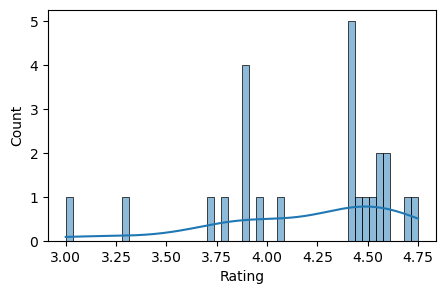

In [66]:
#Plot the distribution of restaurants
plt.figure(figsize = (5,3))
sns.histplot(restaurants['Rating'], kde = True, bins = 50);

In [67]:
#The mean of rating
np.mean(restaurants['Rating'])

4.197916666666667

##### The distribution of restaurants rating is a normal distribution aroud the mean 4.09

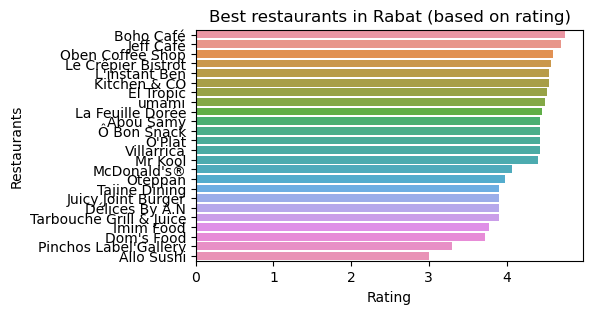

In [68]:
#Barplot the best 25 restaurants in Rabat
plt.figure(figsize = (5,3))
best_restaurants1 = best_restaurants[0:25]
sns.barplot(x = best_restaurants1['Rating'], y = best_restaurants1['Restaurant']);
plt.title('Best restaurants in Rabat (based on rating)');
plt.xlabel('Rating');
plt.ylabel('Restaurants');

### The most famous restaurants (based on number of reviews)

In [69]:
famous_restaurants = restaurants[['Restaurant', 'Number of reviews']].sort_values(by = 'Number of reviews', ascending = False).reset_index(drop = True)
famous_restaurants

,Restaurant,Number of reviews
0,Boho Café,1706
1,Le Crêpier Bistrot,728
2,Tajine Dining,448
3,McDonald's®,361
4,Abou Samy,341
5,Jeff Café,318
6,El Tropic,211
7,Mr Kool,190
8,Ô Bon Snack,129
9,Oben Coffee Shop,112


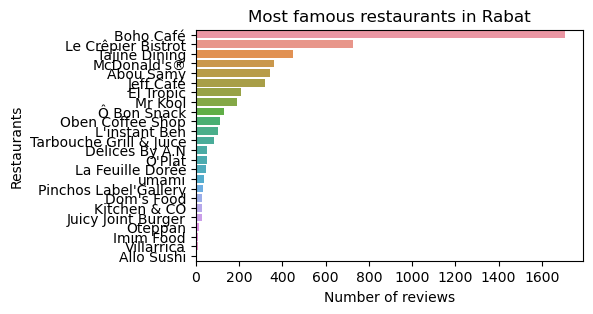

In [70]:
#barplot of the famous restaurants
plt.figure(figsize = (5,3))
most_famous_restaurants = famous_restaurants[0:25]
sns.barplot(x = most_famous_restaurants['Number of reviews'], y = most_famous_restaurants['Restaurant']);
plt.title('Most famous restaurants in Rabat');
plt.xlabel('Number of reviews');
plt.ylabel('Restaurants');

### The correlation between the numbre of reviews and restaurant's rating

In [71]:
correlation = restaurants['Rating'].corr(restaurants['Number of reviews'])
correlation

0.3790776889274009

So clearly there is no correlation between number of reviews and the rating of a restaurant.

### Districts that contain most restaurants.

In [72]:
restaurant_district = restaurants['District'].value_counts()
restaurant_district

Agdal Riyad أكدال الرياض    7
Hassan حسان                 4
El Youssoufia اليوسفية      4
Souissi السويسي             3
يعقوب المنصور               2
                            2
Bettana بطانة               1
Bab Lamrissa باب لمريسة     1
Name: District, dtype: int64

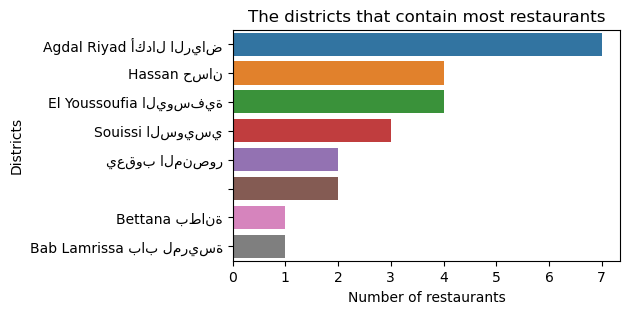

In [73]:
plt.figure(figsize = (5,3))
sns.barplot(x = restaurant_district, y = restaurant_district.index);
plt.title('The districts that contain most restaurants');
plt.xlabel('Number of restaurants');
plt.ylabel('Districts');

### The heat map of restaurants

In [74]:
import folium
from folium.plugins import HeatMap

In [75]:
#Create a base map and zoom on Rabat
basemap=folium.Map(location = [33.995771,-6.841727], zoom_start = 13)

In [76]:
#Add the heat map to our base map
HeatMap(final_data[['Latitude','Longitude']].values.tolist(),max_zoom=20,radius=15,blur=10).add_to(basemap)
basemap

### VI.2 Food analysis

### The most popular food's category in Rabat

In [77]:
#Show the 15 most popular foods in Rabat
food_count = final_data['Category'].value_counts()
food_count[:15]

Pasta        403
Boisson      224
Poisson      100
Entrée        83
Sushi         74
Sandwich      67
Pizza         58
Burger        57
Salade        57
Crêpe         52
Café          49
Dessert       48
Milkshake     21
Tacos         16
Smoothie      11
Name: Category, dtype: int64

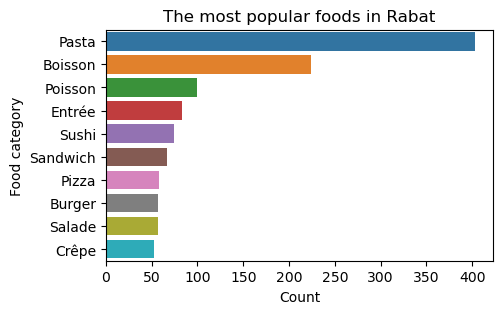

In [78]:
plt.figure(figsize = (5,3))
sns.barplot(x = food_count[:10], y = food_count[:10].index);
plt.title('The most popular foods in Rabat');
plt.xlabel('Count');
plt.ylabel('Food category');

In [79]:
#The mean and median price of food in Rabat
data_by_price = final_data.groupby('Category')['Price'].agg(['mean', 'median'])

food_price = pd.DataFrame({'Category': data_by_price.index,
                           'Mean price': data_by_price['mean'],
                           'Median price': data_by_price['median']}).sort_values(by = "Mean price", ascending = False)

In [80]:
food_price[:15]

,Category,Mean price,Median price
Category,,,
Risotto,Risotto,95.000000,95.000
Noodles,Noodles,90.001250,87.005
Brochetterie,Brochetterie,83.000000,78.000
Grillades,Grillades,79.500000,85.000
Filet,Filet,75.375000,70.000
Tacos,Tacos,70.437500,54.500
Pasta,Pasta,60.173027,48.000
Pizza,Pizza,58.448276,57.000
Salade,Salade,57.473684,59.000


In [81]:
final_data.to_csv("data_Rabat.csv")

### We will create a unique value id for each meal so we can refer to it directly

In [83]:
final_data['id_meal'] = final_data.index

In [92]:
final_data.rename(columns={'index': 'id_meal'}, inplace=True)

In [85]:
final_data = final_data.drop(columns = ['id_meal'])

In [86]:
final_data.to_csv("data_projet.csv")

In [93]:
final_data

,id_meal,Restaurant,Link to glovo,Meal name,Ingredients,Price,Address,Latitude,Longitude,Number of reviews,City,District,Rating,Category
0,0,Tajine Dining,/ma/fr/rabat/tajine-dining/,Khizou Mchermel,Salade de carottes à la marocaine.,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.90,Pasta
1,1,Tajine Dining,/ma/fr/rabat/tajine-dining/,Batata Harra,pommes de terre sautées épicées,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.90,Pasta
2,2,Tajine Dining,/ma/fr/rabat/tajine-dining/,Chlada Tomates et Concombre,Salade Tomates Concombre.,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.90,Pasta
3,3,Tajine Dining,/ma/fr/rabat/tajine-dining/,KEBDA MCHERMLA,( foie de volaille à la marocaine) Olives & ci...,65.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.90,Pasta
4,4,Tajine Dining,/ma/fr/rabat/tajine-dining/,Zaalouk d'Aubergines,Caviar d'aubergines A la marocaine,20.0,"2587+637، Rue de Baghdad, Rabat, Morocco",34.015541,-6.837314,448,RABAT,Hassan حسان,3.90,Salade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,1418,L'instant Ben,/ma/fr/rabat/linstant-ben/,Chocolat Chaud,NaN,20.0,"35 Av. Fal Ould Oumeir, Rabat 10106, Morocco",34.002758,-6.851086,104,RABAT,Agdal Riyad أكدال الرياض,4.55,Boisson
1419,1419,L'instant Ben,/ma/fr/rabat/linstant-ben/,Ice Coffee,NaN,20.0,"35 Av. Fal Ould Oumeir, Rabat 10106, Morocco",34.002758,-6.851086,104,RABAT,Agdal Riyad أكدال الرياض,4.55,Café
1420,1420,L'instant Ben,/ma/fr/rabat/linstant-ben/,Décaféiné,NaN,18.0,"35 Av. Fal Ould Oumeir, Rabat 10106, Morocco",34.002758,-6.851086,104,RABAT,Agdal Riyad أكدال الرياض,4.55,Café
1421,1421,L'instant Ben,/ma/fr/rabat/linstant-ben/,Café Latte,NaN,16.0,"35 Av. Fal Ould Oumeir, Rabat 10106, Morocco",34.002758,-6.851086,104,RABAT,Agdal Riyad أكدال الرياض,4.55,Café


## V. Creating a Collaborative Based Recommendation System
This chapter contains:
* Genrating a dataframe that contains 1000 client, each client has between 50 and 150 reviews for different meals, the reviews are between 0 and 5.
* Creating a collaborative Based Recommendation System to predict the ratings for each client based on other clients preferences.
* Using K cross fold to test the performance of our model using MSE.

### V.1. Create a random dataframe
This data frame will contain 1000 rows, each row correspond to a specific client, a client can give at least 50 reviews and the reviews are between 0 and 5.

In [94]:
import random

# List of elements to evaluate
id_meal = list(final_data['id_meal'])

# Dictionary to store client data
dic = {}

# Generate rating for each client
for client_id in range(1, 1001):
    num_notes = random.randint(50, min(len(id_meal), 150))
    selected_id = set(random.sample(id_meal, num_notes))  # Use a set for faster lookup
    client_data = {meal_id: (random.uniform(0, 5) if meal_id in selected_id else np.nan) for meal_id in id_meal}
    dic[client_id] = client_data

# Create a dataframe for the dic
df = pd.DataFrame.from_dict(dic, orient='index')

# Show dataframe
print(df)

      0     1     2         3     4         5     6         7     8     \
1      NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
2      NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
3      NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
4      NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
5      NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
...    ...   ...   ...       ...   ...       ...   ...       ...   ...   
996    NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
997    NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   
998    NaN   NaN   NaN       NaN   NaN       NaN   NaN  2.718911   NaN   
999    NaN   NaN   NaN  0.133839   NaN  4.591648   NaN       NaN   NaN   
1000   NaN   NaN   NaN       NaN   NaN       NaN   NaN       NaN   NaN   

          9     ...  1413      1414      1415  1416  1417      1418      1419  \
1          NaN  ...   NaN     

In [95]:
#We will observe the number of missing values for each meal index.
df.isna().sum()

0       921
1       937
2       932
3       940
4       927
       ... 
1418    920
1419    936
1420    930
1421    939
1422    927
Length: 1423, dtype: int64

### V.2. Build a collaborative recommendation system
In this part of our project we will buils a collaborative recommendation systeme, using the dataframe that we've generated above, we will predict th rating that can be given by  client for a givean deach.

In [96]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

def normalize(pred_ratings):
    '''
    This function will normalize the input pred_ratings
    
    params:
        pred_ratings (List -> List) : The prediction ratings 
    '''
    return (pred_ratings - pred_ratings.min()) / (pred_ratings.max() - pred_ratings.min())
  
def generate_prediction_df(mat, pt_df, n_factors):
    '''
    This function will calculate the single value decomposition of the input matrix
    given n_factors. It will then generate and normalize the user rating predictions.
    
    params:
        mat : scipy csr matrix corresponding to the pivot table (pt_df)
        pt_df : pandas dataframe which is a pivot table
        n_factors : Number of singular values and vectors to compute. 
    '''
    
    if not 1 <= n_factors < min(mat.shape):
        raise ValueError("Must be 1 <= n_factors < min(mat.shape)")
        
    # matrix factorization
    u, s, v = svds(mat, k = n_factors)
    s = np.diag(s)

    # calculate pred ratings
    pred_ratings = np.dot(np.dot(u, s), v) 
    pred_ratings = normalize(pred_ratings)
    
    # convert to df
    pred_df = pd.DataFrame(
        pred_ratings,
        columns = pt_df.columns,
        index = list(pt_df.index)
    ).transpose()
    return pred_df

In [101]:
df

,0,1,2,3,4,5,6,7,8,9,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.280035,NaN,NaN,NaN,0.579267,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.271605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.794731,NaN,NaN,NaN,1.103170,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75442,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.718911,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,NaN,NaN,NaN,0.133839,NaN,4.591648,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.623704,NaN,NaN,NaN,NaN


We will generate a pivot table using our dataframe

In [102]:
pt_df = df.fillna(0)

In [103]:
# Convert to a csr matrix
mat = pt_df.values
mat = csr_matrix(mat)

In [104]:
# Using the function generate_prediction_df, we will generate ratings for all meals
pred_df = generate_prediction_df(mat, pt_df, 10)

In [105]:
pred_df

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
0,0.456459,0.360284,0.413280,0.598905,0.468850,0.376479,0.348588,0.556260,0.484370,0.403266,...,0.553010,0.395010,0.440631,0.353076,0.390313,0.452742,0.378309,0.419814,0.390402,0.376029
1,0.470631,0.364452,0.412661,0.356677,0.400999,0.410760,0.454316,0.442434,0.416891,0.400385,...,0.456347,0.385308,0.400260,0.366357,0.420670,0.424415,0.363166,0.402139,0.366474,0.377297
2,0.412965,0.373208,0.422768,0.427582,0.368961,0.399798,0.425371,0.408032,0.404483,0.356236,...,0.360810,0.381483,0.412816,0.379485,0.406225,0.384056,0.372735,0.412554,0.398689,0.382251
3,0.462283,0.395832,0.337664,0.439854,0.400061,0.447222,0.521199,0.383038,0.360928,0.408281,...,0.358164,0.373896,0.386948,0.483287,0.448994,0.312409,0.393762,0.412458,0.370497,0.389350
4,0.371121,0.390232,0.439709,0.240017,0.293407,0.399228,0.440947,0.376596,0.449206,0.339941,...,0.444433,0.403782,0.429174,0.422473,0.406455,0.519809,0.369872,0.397422,0.471951,0.511372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.269400,0.393167,0.346076,0.408128,0.356435,0.416986,0.350232,0.462034,0.443155,0.435267,...,0.571941,0.373641,0.415270,0.479786,0.373802,0.512905,0.383062,0.392856,0.433786,0.435723
1419,0.445398,0.353422,0.361552,0.462518,0.403434,0.403390,0.377879,0.445984,0.415310,0.418917,...,0.493061,0.383719,0.412932,0.401503,0.397636,0.454488,0.367807,0.383431,0.390577,0.396475
1420,0.444597,0.371275,0.395650,0.479934,0.388622,0.411706,0.348085,0.454740,0.408594,0.413419,...,0.421715,0.378826,0.416521,0.391451,0.373927,0.511902,0.359024,0.401646,0.392237,0.369333
1421,0.406904,0.352091,0.347804,0.528305,0.384197,0.390390,0.397843,0.400001,0.432414,0.390964,...,0.438148,0.390566,0.423876,0.433170,0.425497,0.311169,0.385302,0.384848,0.414305,0.425715


In [106]:
df.shape

(1000, 1423)

### V.3. Evaluate our system
Using the K fold cross validation and the mean square error, we will devide our dataframe on 5 dataframes and test the model 5 times to calculate the mean of our MSE.

In [107]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [108]:
# Set the number of folds
k = 5

# Initialize evaluation metric
eval_metric = mean_squared_error

In [109]:
# Convert pred_df to a numpy array for indexing convenience
pred_array = pred_df.values

# Initialize a list to store the evaluation results for each fold
eval_results = []

In [110]:
# Perform k-fold cross-validation
kf = KFold(n_splits=k)
for train_index, test_index in kf.split(pred_array.T):
    # Transpose the data to get consistent dimensions
    train_data = pred_array[:, train_index]
    test_data = pred_array[:, test_index]

    # Calculate predictions for the test set
    pred_test = normalize(test_data)

    # Evaluate performance using the chosen evaluation metric
    eval_score = eval_metric(test_data, pred_test)
    eval_results.append(eval_score)

In [111]:
# Calculate average performance across all folds
avg_performance = np.mean(eval_results)

In [112]:
avg_performance

0.0009656579085895349

We know that after normalizing the results, the obtained values are between 0 and 1, and with a mean squared error of 0.009, we are confident that the code predicts the ratings accurately.

# Conclusion
In this project, we were able to extract the necessary data to analyze the gastronomy sector in Rabat. 
Subsequently, we analyzed this data to gather more information about the sector. 
Finally, we created a reliable recommendation system that allows consumers to make choices based on their preferences among several recommended options.